# Исследование мобильного приложения стартапа по продажам продуктов питания

<a id="Начало_проекта"></a>

<div style="border:solid black 2px; padding: 20px">

Проведем исследовательский анализ на данных мобильного приложения стартапа по продажам продуктов питания.

Дизайнеры хотят поменять шрифты во всем приложении, но у менеджеров есть сомнения, что пользователям будет непривычно. Примем решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Цели исследования:** 
* Разобраться, как ведут себя пользователи мобильного приложения.
* Изучить воронку продаж. 
* Исследовать результаты A/A/B-эксперимента.
* Принять решение по результатам A/A/B-эксперимента.

**Ход исследования**

Данные о поведении пользователей получили из файла `/datasets/logs_exp.csv`. О качестве данных нам ничего не известно. Поэтому перед проверкой гипотез проведем обзор данных. 

Таким образом, исследование пройдёт в несколько этапов:
1. [Загрузка и обзор данных](#загрузка)
2. [Предобработка данных](#предобработка)
3. [Исследовательский анализ данных](#исследовательский)
4. [Воронка событий](#воронка)
5. [Анализ A/A/B-эксперимента](#эксперимент)
7. [Итоги исследования](#итоги)

**Описание данных**

Файл *logs_exp.csv*:
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


</div>

[Начало_проекта](#Начало_проекта)

<a id="загрузка"></a>

## Загрузка и обзор данных

### Импортируем библиотеки. Считываем данные из csv-файла и сохраняем в переменную

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy import stats as st
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import math as mth

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t') 
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')

### Получим общую информацию о таблице

In [3]:
def data_info(data):
    print('-'*50)
    print('Первые 5 строк')
    print('-'*50)
    display(data.head())
    print('-'*50)
    print('Общая информация')
    print('-'*50)
    data.info()
    print('-'*50)
    print('Основные статистические данные')
    print('-'*50)
    display(data.describe().T)
    print('-'*50)
    print('Подсчет пропусков')
    print('-'*50)
    display(data.isna().sum())
    print('-'*50)
    print('Проверка явных дубликатов')
    print('-'*50)
    print(data.duplicated().sum())
    print('-'*50)
    print('Размер таблицы')
    print('-'*50)
    print(data.shape)

In [4]:
data_info(data)

--------------------------------------------------
Первые 5 строк
--------------------------------------------------


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


--------------------------------------------------
Общая информация
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
--------------------------------------------------
Основные статистические данные
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,244126.0,4.627568e+18,2.642425e+18,6.888747e+15,2.372212e+18,4.623192e+18,6.932517e+18,9.222603e+18
EventTimestamp,244126.0,1.564914e+09,1.771343e+05,1.564030e+09,1.564757e+09,1.564919e+09,1.565075e+09,1.565213e+09
ExpId,244126.0,2.470223e+02,8.244339e-01,2.460000e+02,2.460000e+02,2.470000e+02,2.480000e+02,2.480000e+02


--------------------------------------------------
Подсчет пропусков
--------------------------------------------------


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

--------------------------------------------------
Проверка явных дубликатов
--------------------------------------------------
413
--------------------------------------------------
Размер таблицы
--------------------------------------------------
(244126, 4)


<div style="border:solid green 2px; padding: 20px">

Выводы:
* Пропусков нет.
* Явных дубликатов 413. Всего строк 244126. Удалим строки с явными дубликатами.
* Добавим столбец даты и времени, а также отдельный столбец дат.
* Приведем заголовки столбцов к хорошему стилю (змеиный регистр).

</div>

[Начало_проекта](#Начало_проекта)

<a id="предобработка"></a>

## Предобработка данных

### Переименование столбцов

In [5]:
data = data.rename(columns={'EventName': 'event_name',
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_timestamp',
                            'ExpId': 'exp_id'})
data.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

<div style="border:solid green 2px; padding: 20px">
    
Привели заголовки столбцов к хорошему стилю (змеиному регистру).

</div>

### Удаление явных дубликатов

In [6]:
data = data.drop_duplicates().reset_index(drop=True) # удаление явных дубликатов, создание новых индексов и удаление старых

In [7]:
data.duplicated().sum() # проверка на отсутствие явных дубликатов

0

<div style="border:solid green 2px; padding: 20px">
    
Явные дубликаты удалили.

</div>

### Проверка неявных дубликатов

In [8]:
data['event_name'].value_counts() # просмотр уникальных значений и количество строк

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

In [9]:
data['exp_id'].value_counts() # просмотр уникальных значений и количество строк

exp_id
248    85582
246    80181
247    77950
Name: count, dtype: int64

<div style="border:solid green 2px; padding: 20px">

Не выявлено неявных дубликатов.

</div>

### Добавление столбцов с датой и временем

<div style="border:solid black 2px; padding: 20px">

Добавим столбец даты и времени, столбец дата и столбец по часам.

</div>

In [10]:
data['event_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] =  pd.to_datetime(data['event_time']).dt.date
data['hour'] =  pd.to_datetime(data['event_time']).dt.hour
data.head()

,event_name,user_id,event_timestamp,exp_id,event_time,date,hour
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,4
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,11


In [11]:
data.dtypes

event_name                 object
user_id                     int64
event_timestamp             int64
exp_id                      int64
event_time         datetime64[ns]
date                       object
hour                        int32
dtype: object

### Категоризация данных

#### Группы A/A/B-теста

<div style="border:solid black 2px; padding: 20px">

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

Сделаем категоризацию:
* 246 - А1
* 247 - А2
* 248 - В

</div>

In [12]:
# функция возвращает категорию по значению от exp_id, используя правила:
def type_exp_id(row): 
    if row['exp_id'] == 246:
        return 'A1'
    elif row['exp_id'] == 247:
        return 'A2'
    elif row['exp_id'] == 248:
        return 'B'
    return 'Нет данных'

data['group'] = data.apply(type_exp_id, axis=1) # добавляем новый столбец

# проверяем категоризацию
data.groupby(['exp_id', 'group'])['user_id'].agg('count')

exp_id  group
246     A1       80181
247     A2       77950
248     B        85582
Name: user_id, dtype: int64

#### Категоризация событий

<div style="border:solid black 2px; padding: 20px">

Сделаем расшифровку названий событий в отдельном столбце.

</div>

In [13]:
# функция возвращает категорию по значению от event_name, используя правила:
def type_event_name(row): 
    if row['event_name'] == 'MainScreenAppear':
        return 'Просмотрел главную страницу'
    elif row['event_name'] == 'OffersScreenAppear':
        return 'Перешел на страницу Каталог'
    elif row['event_name'] == 'CartScreenAppear':
        return 'Перешел на страницу Корзина'
    elif row['event_name'] == 'PaymentScreenSuccessful':
        return 'Перешел на страницу Успешная оплата'
    elif row['event_name'] == 'Tutorial':
        return 'Посмотрел страницу Руководство'
    return 'Нет данных'

data['event_type'] = data.apply(type_event_name, axis=1) # добавляем новый столбец

# проверяем категоризацию
data.groupby(['event_name', 'event_type'])['user_id'].agg('count')

event_name               event_type                         
CartScreenAppear         Перешел на страницу Корзина             42668
MainScreenAppear         Просмотрел главную страницу            119101
OffersScreenAppear       Перешел на страницу Каталог             46808
PaymentScreenSuccessful  Перешел на страницу Успешная оплата     34118
Tutorial                 Посмотрел страницу Руководство           1018
Name: user_id, dtype: int64

#### Добавление столбца с названием магазина

In [14]:
# добавим столбец с условным названием магазина для удобства построения сводных
data['store'] = 'store'
data.head(2)

,event_name,user_id,event_timestamp,exp_id,event_time,date,hour,group,event_type,store
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,4,A1,Просмотрел главную страницу,store
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11,A1,Просмотрел главную страницу,store


### Проверка дубликатов пользователей в разных группах

<div style="border:solid black 2px; padding: 20px">

Проверим, есть ли дубликаты пользователей в группах А1, А2 и В.

</div>

In [15]:
# Группируем пользователей по группам теста
id_duplicates = data.pivot_table(index=['group', 'user_id'], values='event_name', aggfunc='count').reset_index()

# Добавляем столбец для определения дубликатов пользователей по группам
id_duplicates['boolean'] = id_duplicates['user_id'].duplicated()
id_duplicates.head(2)

,group,user_id,event_name,boolean
0,A1,6888746892508752,1,False
1,A1,6922444491712477,47,False


In [16]:
print('-'*50)
print('Дубликаты пользователей в группах теста:', id_duplicates[id_duplicates['boolean'] == True]['boolean'].count())
print('Уникальные пользователи в группах теста:', id_duplicates[id_duplicates['boolean'] == False]['boolean'].count())
print('-'*50)

--------------------------------------------------
Дубликаты пользователей в группах теста: 0
Уникальные пользователи в группах теста: 7551
--------------------------------------------------


<div style="border:solid green 2px; padding: 20px">

Нет дубликатов пользователей в разных группах.

</div>

[Начало_проекта](#Начало_проекта)

<a id="исследовательский"></a>

## Исследовательский анализ данных

### Количество событий и пользователей в логе

<div style="border:solid black 2px; padding: 20px">

Рассмотрим:
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?

</div>

In [17]:
data_store = data.pivot_table(index='store', values=['event_type', 'event_name', 'user_id'],
                              aggfunc={'event_type':'count', 'event_name':'nunique','user_id': 'nunique'})
data_store['events_per_user'] = (data_store['event_type'] / data_store['user_id']).round()
data_store.columns = ['Количество уникальных событий', 'Всего событий',
                      'Количество уникальных пользователей', 'Количество событий на пользователя']
data_store

,Количество уникальных событий,Всего событий,Количество уникальных пользователей,Количество событий на пользователя
store,,,,
store,5,243713,7551,32.0


In [18]:
# сводная для построения графика ниже
events_per_user = data.pivot_table(index=['user_id'], values='event_type', aggfunc={'event_type': 'count'})\
                      .rename(columns= {'event_type': 'Количество событий на пользователя'})
events_per_user.head(2)

,Количество событий на пользователя
user_id,
6888746892508752,1
6909561520679493,5


In [19]:
events_per_user['Количество событий на пользователя'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: Количество событий на пользователя, dtype: float64

In [20]:
print('Количество событий на пользователя больше 100:',
      len(events_per_user[events_per_user['Количество событий на пользователя'] >= 100]))
# считаем количество строк по условию

Количество событий на пользователя больше 100: 303


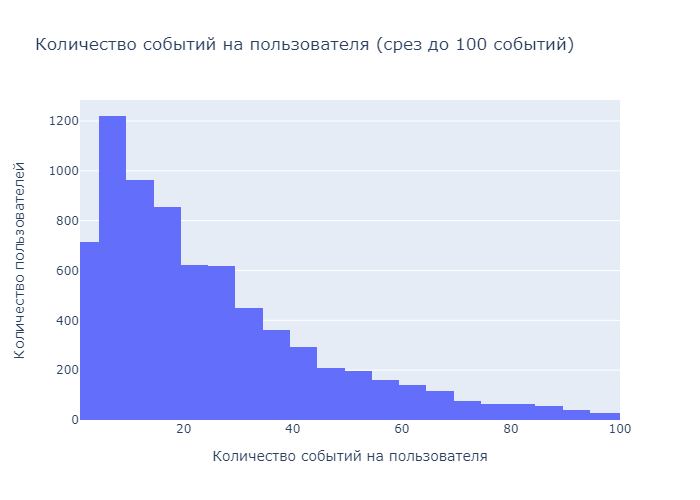

In [21]:
fig_hist = px.histogram(events_per_user, x='Количество событий на пользователя',
                       range_x=[1, 100],
                       title='Количество событий на пользователя (срез до 100 событий)')
fig_hist.layout.yaxis.title.text = 'Количество пользователей'
fig_hist.show('png')

<div style="border:solid green 2px; padding: 20px">

**Количество событий и пользователей в логе.**

| store  | Количество уникальных событий| Всего событий| Количество уникальных пользователей| Количество событий на пользователя| 
|:-------|:----------------------------:|:------------:|:----------------------------------:|:---------------------------------:|
|store   | 5                            |243713        | 7551                               | 32                                |


| Количество событий на пользователя  | mean | median | min | max  | 
|:------------------------------------|:----:|:------:|:---:|:----:|
|Количество событий на пользователя   | 32   |20      | 1   | 2307 |                          

На гистограмме видим длинных хвост по количеству событий на пользователя.

При срезе до 100 событий на пользователя, пик количества событий на пользователя в диапазоне 5-9 событий.

</div>

### Период отчетности

#### Период

In [22]:
data.groupby('date')['user_id'].agg('count')

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: user_id, dtype: int64

In [23]:
print('Минимальная дата', data['date'].min())
print('Максимальная дата', data['date'].max())

Минимальная дата 2019-07-25
Максимальная дата 2019-08-07


<div style="border:solid green 2px; padding: 20px">

Период: с 2019-07-25 по 2019-08-07 (14 дней):
* Минимальная дата 2019-07-25
* Максимальная дата 2019-08-07

</div>

#### Количество событий по дням

<div style="border:solid black 2px; padding: 20px">

Проверим количество событий по дням в разных группах теста.

</div>

In [24]:
event_cnt_group = data.pivot_table(index='date', columns='group', values='event_name', aggfunc='count')\
                      .reset_index()
event_cnt_group.style.background_gradient(cmap='Blues', axis=0)\
               .set_caption('Количество событий по дням')

group,date,A1,A2,B
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


In [25]:
event_cnt = data.pivot_table(index=['date', 'group'], values='event_name', aggfunc='count').reset_index()
df_long = event_cnt.set_index('date').reset_index()
df_long.columns = ['Дата', 'Группа', 'Количество событий']
df_long.head(2)

,Дата,Группа,Количество событий
0,2019-07-25,A1,4
1,2019-07-25,A2,1


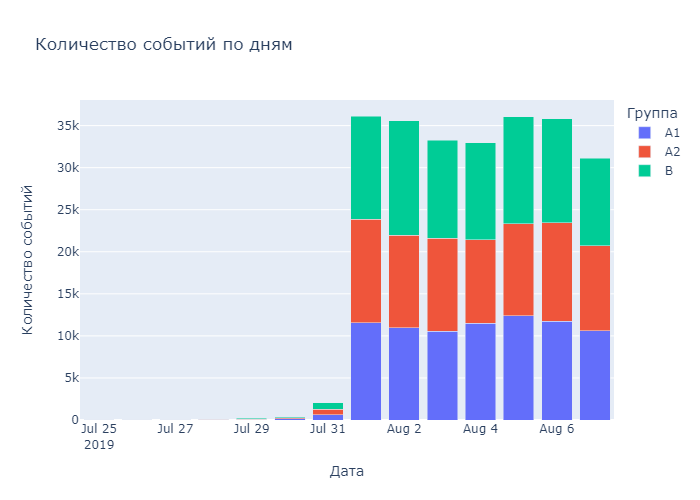

In [26]:
fig_event_cnt_group = px.bar(data_frame=df_long, x='Дата', y='Количество событий',
                             color='Группа', barmode='stack', title='Количество событий по дням')
fig_event_cnt_group.show('png')

In [27]:
# добавим 'месяц' в таблицу для построения графика pie
# функция возвращает категорию по значению от 'Дата', используя правила:
july = dt.date(2019, 7, 31)
august = dt.date(2019, 8, 7)

def type_date(row): 
    if row['Дата'] <= july:
        return '(7) Июль'
    elif row['Дата'] <= august:
        return '(8) Август'
    return 'Нет данных'

df_long['Месяц'] = df_long.apply(type_date, axis=1) # добавляем новый столбец

# проверяем категоризацию
df_long.groupby(['Месяц', 'Дата'])['Количество событий'].agg('sum')

Месяц       Дата      
(7) Июль    2019-07-25        9
            2019-07-26       31
            2019-07-27       55
            2019-07-28      105
            2019-07-29      184
            2019-07-30      412
            2019-07-31     2030
(8) Август  2019-08-01    36141
            2019-08-02    35554
            2019-08-03    33282
            2019-08-04    32968
            2019-08-05    36058
            2019-08-06    35788
            2019-08-07    31096
Name: Количество событий, dtype: int64

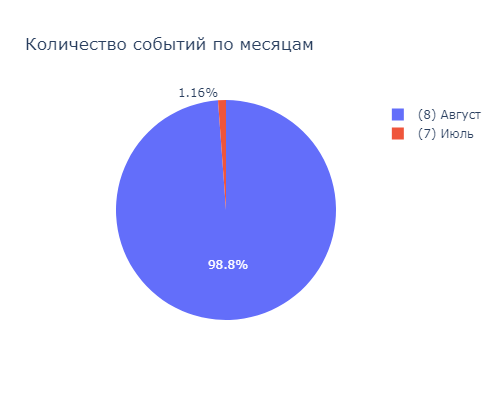

In [28]:
fig_month = px.pie(df_long, values='Количество событий', names='Месяц',
                   title = 'Количество событий по месяцам',
                   width=500, height=400)
fig_month.show('png')

<div style="border:solid green 2px; padding: 20px">

По графику видим не одинаково полные данные за весь период:
* Июль 2826 событий (доля 1.2%).
* Август 240887 событий (доля 98.8%).

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 

На самом деле мы располагаем полными данные за 7 дней с 1 по 7 августа 2019 г.

Таким образом, отбросим данные за июль.

</div>

#### Период с одинаково полными данными

<div style="border:solid black 2px; padding: 20px">

Создадим новую таблицу, где уберем данные за июль.

</div>

In [29]:
data['date'] = pd.to_datetime(data['date'])
data_aug = data.query('date > "2019-07-31"')
data_aug.head(2)

,event_name,user_id,event_timestamp,exp_id,event_time,date,hour,group,event_type,store
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,0,A1,Посмотрел страницу Руководство,store
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,0,A1,Просмотрел главную страницу,store


In [30]:
data_aug_date = data_aug.pivot_table(index='date', values='event_name', aggfunc='count')\
                        .rename(columns= {'event_name': 'Количество событий'})
data_aug_date.style.set_caption('Количество событий август')

,Количество событий
date,
2019-08-01 00:00:00,36141
2019-08-02 00:00:00,35554
2019-08-03 00:00:00,33282
2019-08-04 00:00:00,32968
2019-08-05 00:00:00,36058
2019-08-06 00:00:00,35788
2019-08-07 00:00:00,31096


In [31]:
# сравнение исходника и новой таблицы
print('Количество событий август (новая таблица):', len(data_aug))
print('Количество событий август (исходник):', len(data.query('date > "2019-07-31"')))

Количество событий август (новая таблица): 240887
Количество событий август (исходник): 240887


In [32]:
data_users = data.pivot_table(index='group', values='user_id', aggfunc='nunique')\
                 .rename(columns= {'user_id': 'Уникальные пользователи весь период'})

data_aug_users = data_aug.pivot_table(index='group', values='user_id', aggfunc='nunique')\
                         .rename(columns= {'user_id': 'Уникальные пользователи август'})

check_users = data_users.merge(data_aug_users, left_on='group', right_on='group')
check_users['Разница'] = check_users['Уникальные пользователи весь период'] - check_users['Уникальные пользователи август']

check_users.loc['total'] = check_users.sum(numeric_only=True)
check_users

,Уникальные пользователи весь период,Уникальные пользователи август,Разница
group,,,
A1,2489,2484,5
A2,2520,2513,7
B,2542,2537,5
total,7551,7534,17


<div style="border:solid green 2px; padding: 20px">

Сформировали новую таблицу, где оставили данные только за август.

Проверили, что количество событий за август совпадает с исходным файлом (240887 событий).

Проверили количество уникальных пользователей. Отбросив данные за июль, потеряли только 17 уникальных пользователей из 7551.

</div>

#### Время

<div style="border:solid black 2px; padding: 20px">

Посмотрим на время, в которое чаще заходят пользователи в приложение.

</div>

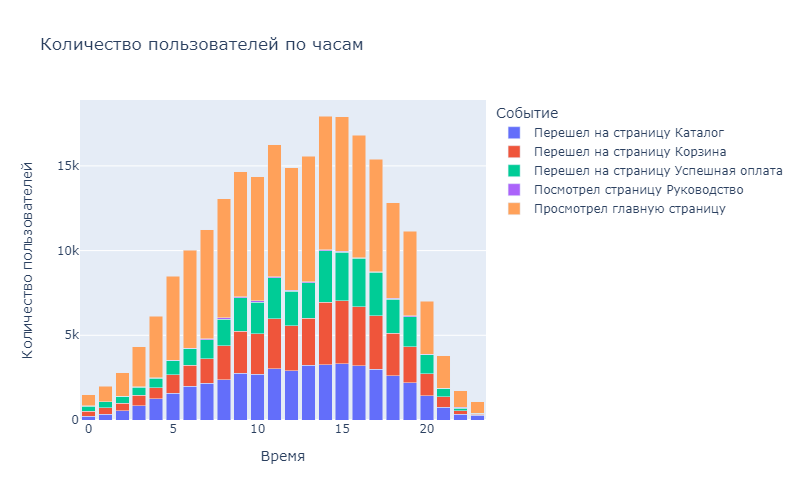

In [33]:
hour_cnt = data_aug.pivot_table(index=['hour', 'event_type'], values='user_id', aggfunc='count').reset_index()
hour_long = hour_cnt.set_index('hour').reset_index()
hour_long.columns = ['Время', 'Событие', 'Количество пользователей']
fig_hour_long = px.bar(data_frame=hour_long, x='Время', y='Количество пользователей',
                       color='Событие', barmode='stack', title='Количество пользователей по часам',
                       width=800, height=500)
fig_hour_long.show('png')

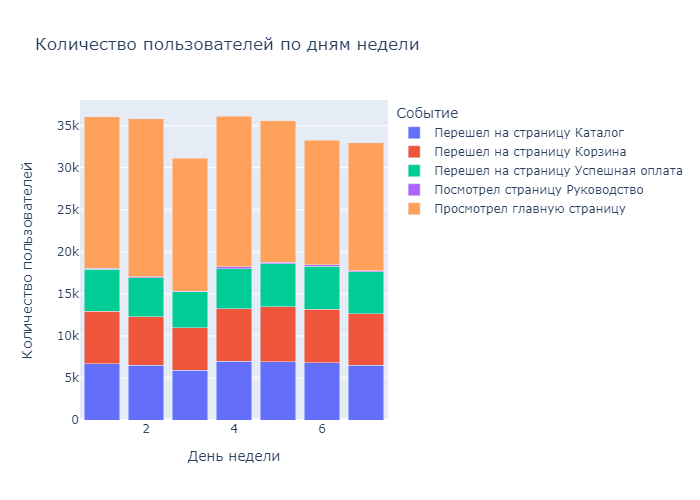

In [34]:
data_aug_week_day = data_aug.pivot_table(index=['date', 'event_type'], values='user_id', aggfunc='count')\
                            .reset_index()
data_aug_week_day['week'] = data_aug_week_day['date'].dt.isocalendar().day
week_day = data_aug_week_day.set_index('week').reset_index()
week_day.columns = ['День недели', 'День' , 'Событие', 'Количество пользователей']
fig_week_day = px.bar(data_frame=week_day, x='День недели', y='Количество пользователей',
                      color='Событие', barmode='stack', title='Количество пользователей по дням недели')
fig_week_day.show('png')

<div style="border:solid green 2px; padding: 20px">

Чаще всего пользователи заходят в приложение с 9:00 до 17:00.

Самое популярное время в приложении 14:00 и 15:00.

За одну отчетную неделю меньше всего пользователей в среду. Данных за одну неделю недостаточно для того, чтобы говорить о тренде, будем иметь ввиду эту информацию для дальнейших исследований.

</div>

### Вывод

<div style="border:solid blue 2px; padding: 20px">


**Количество событий и пользователей в логе.**

| store  | Количество уникальных событий| Всего событий| Количество уникальных пользователей| Количество событий на пользователя| 
|:-------|:----------------------------:|:------------:|:----------------------------------:|:---------------------------------:|
|store   | 5                            |243713        | 7551                               | 32                                |


| Количество событий на пользователя  | mean | median | min | max  | 
|:------------------------------------|:----:|:------:|:---:|:----:|
|Количество событий на пользователя   | 32   |20      | 1   | 2307 |                          

На гистограмме видим длинных хвост по количеству событий на пользователя.

При срезе до 100 событий на пользователя, пик количества событий на пользователя в диапазоне 5-9 событий.

---

**Период отчета:** с 2019-07-25 по 2019-08-07 (14 дней):
* Минимальная дата 2019-07-25
* Максимальная дата 2019-08-07

По графику видим не одинаково полные данные за весь период:
* Июль 2826 событий (доля 1.2%).
* **Август 240887 событий (доля 98.8%).**

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 

На самом деле мы располагаем полными данные за 7 дней с 1 по 7 августа 2019 г.

Таким образом, отбросили данные за июль.

Отбросив данные за июль, потеряли только 17 уникальных пользователей из 7551.

**Время.**

Чаще всего пользователи заходят в приложение с 9:00 до 17:00.

Самое популярное время в приложении 14:00 и 15:00.

За одну отчетную неделю меньше всего пользователей в среду. Данных за одну неделю недостаточно для того, чтобы говорить о тренде, будем иметь ввиду эту информацию для дальнейших исследований.

</div>

[Начало_проекта](#Начало_проекта)

<a id="воронка"></a>

## Воронка событий

### Проверка данных в разрезе событий

<div style="border:solid black 2px; padding: 20px">

Посмотрим:
* Какие события есть в логах, как часто они встречаются.
* Сколько пользователей совершали каждое из этих событий.
* Долю пользователей, которые хоть раз совершали событие.

</div>

In [35]:
chute = data_aug.pivot_table(index='event_type', values=['event_name', 'user_id'],
                             aggfunc={'event_name': 'count', 'user_id': 'nunique'})\
                .sort_values(by='event_name', ascending=False)
chute['events_share'] = (chute['event_name'] / data_aug['event_name'].count() * 100).round(1)
chute['share_users_by_event'] = (chute['user_id'] / data_aug['user_id'].nunique() * 100).round(1)
chute.columns = ['Количество событий итого', 'Количество уникальных пользователей',
                 'Доля по частоте событий (%)', 'Доля пользователей, хоть раз совершивших событие (%)']

chute.style.format("{:.1f}").background_gradient(axis=0)

,Количество событий итого,Количество уникальных пользователей,Доля по частоте событий (%),"Доля пользователей, хоть раз совершивших событие (%)"
event_type,,,,
Просмотрел главную страницу,117328.0,7419.0,48.7,98.5
Перешел на страницу Каталог,46333.0,4593.0,19.2,61.0
Перешел на страницу Корзина,42303.0,3734.0,17.6,49.6
Перешел на страницу Успешная оплата,33918.0,3539.0,14.1,47.0
Посмотрел страницу Руководство,1005.0,840.0,0.4,11.1


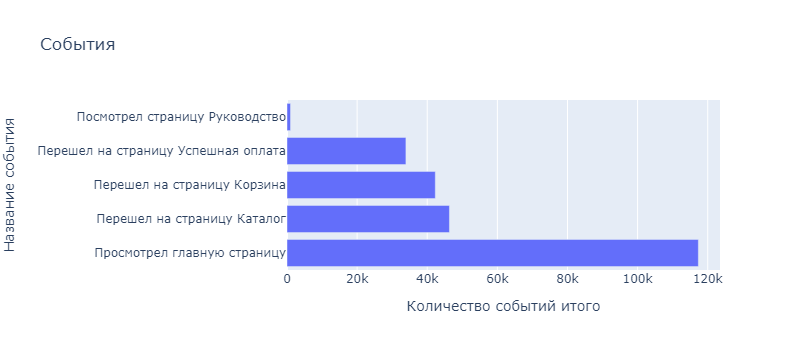

In [36]:
df_chute = chute.reset_index().rename(columns={'event_type': 'Название события'})
fig_chute_event = px.bar(data_frame=df_chute, y='Название события', x='Количество событий итого',
                         barmode='group', title='События', width=800, height=350)
fig_chute_event.show('png')

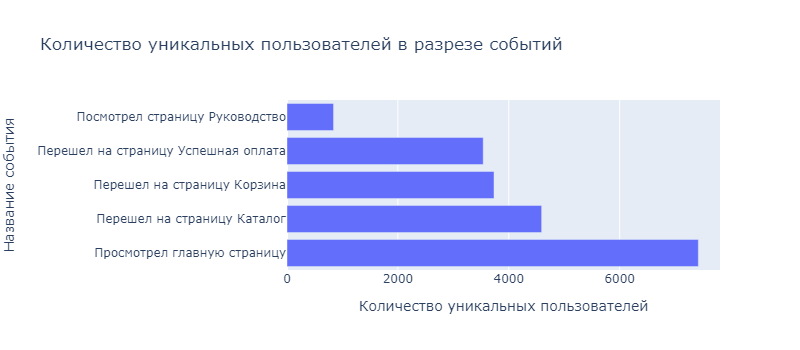

In [37]:
fig_chute_event = px.bar(data_frame=df_chute, y='Название события', x='Количество уникальных пользователей',
                         barmode='group', title='Количество уникальных пользователей в разрезе событий',
                         width=800, height=350)
fig_chute_event.show('png')

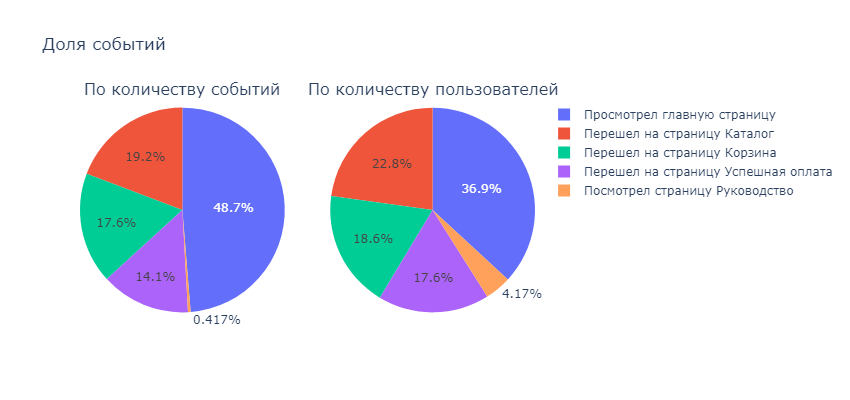

In [38]:
labels_events = ['Перешел на страницу Каталог', 'Перешел на страницу Корзина',
                 'Перешел на страницу Успешная оплата', 'Посмотрел страницу Руководство', 'Просмотрел главную страницу']

values1 = data_aug.groupby('event_type')['event_name'].count()
values2 = data_aug.groupby('event_type')['user_id'].nunique()

fig_events_show = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],
                                subplot_titles=['По количеству событий', 'По количеству пользователей'])

fig_events_show.add_trace(go.Pie(values=values1, labels=labels_events, domain=dict(x=[0, 0.5]),
     name='Доля по количеству событий'), row=1, col=1)

fig_events_show.add_trace(go.Pie(values=values2, labels=labels_events, domain=dict(x=[0.5, 1.0]),
     name='Доля по количеству пользователей'), row=1, col=2)

fig_events_show.update_layout(title_text='Доля событий',width=850, height=400)

fig_events_show.show('png')

In [39]:
# создаем таблицу без события 'Посмотрел страницу Руководство'
data_aug_wo_tutorial = data_aug[data_aug['event_name'] != 'Tutorial']
# проверяем срез
data_aug_wo_tutorial.groupby('event_name')['event_type'].agg('count')

event_name
CartScreenAppear            42303
MainScreenAppear           117328
OffersScreenAppear          46333
PaymentScreenSuccessful     33918
Name: event_type, dtype: int64

<div style="border:solid green 2px; padding: 20px">

В файле присутствуют 5 событий:

| Событие                           | Количество событий | Доля по частоте(%)| Доля пользователей, хоть раз совершивших событие (%)|
|:----------------------------------|:------------------:|:-----------------:| ---------------------------------------------------:|
|Просмотрел главную страницу        | 117328             |48.7               |  98.5                                               |
|Перешел на страницу Каталог        | 46333              |19.2               |  61.0                                               |
|Перешел на страницу Корзина        | 42303              |17.6               |  49.6                                               |
|Перешел на страницу Успешная оплата| 33918              |14.1               |  47.0                                               |
|Посмотрел страницу Руководство     | 1005               |0.4                |  11.1                                               |

* Самое популярное событие 'Просмотрел главную страницу':
    - Количество событий 117328
    - Доля по частоте событий 48.7%.
    - Доля по количеству пользователей 36.9%.
    - Доля пользователей, хоть раз совершивших данное событие 98.5%. Предположение, почему в первом пункте не 100%: пользователь мог зайти по рекламной ссылке на конкретный товар, или получить ссылку на конкретный товар от знакомого.

* Считаем, что все события происходят в порядке, который мы наблюдаем при сортировке частоты событий по убыванию:
1. Просмотрел главную страницу
2. Перешел на страницу Каталог
3. Перешел на страницу Корзина
4. Перешел на страницу Успешная оплата

* Исключение - это событие 'Посмотрел страницу Руководство'. Данную страницу пользователь мог смотреть в любой последовательности после посещения главной страницы. Доля по частоте событий 0.4%. В связи с этим данное событие не будем учитывать при расчете воронки.

</div>

### Воронка событий

<div style="border:solid black 2px; padding: 20px">

Построим воронку событий.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

</div>

In [40]:
funnel_data_aug = data_aug_wo_tutorial.pivot_table(index='event_type', values='user_id', aggfunc={'user_id': 'nunique'})\
                                      .sort_values(by='user_id', ascending=False)
funnel_data_aug = funnel_data_aug.reset_index()
funnel_data_aug

,event_type,user_id
0,Просмотрел главную страницу,7419
1,Перешел на страницу Каталог,4593
2,Перешел на страницу Корзина,3734
3,Перешел на страницу Успешная оплата,3539


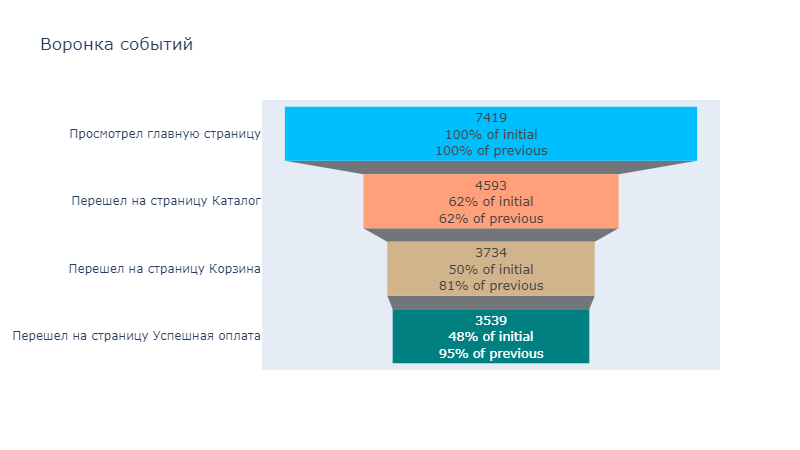

In [41]:
event_types_list = funnel_data_aug['event_type'].tolist()
user_id = funnel_data_aug['user_id'].tolist()

fig_funnel = go.Figure(go.Funnel(y=event_types_list, x=user_id,
        textfont_size=30, marker={'color': ['deepskyblue', 'lightsalmon', 'tan', 'teal']},
        textposition='inside', textinfo='value + percent initial + percent previous'))

fig_funnel.update_layout(title='Воронка событий', width=800, height=450)
fig_funnel.show('png')

<div style="border:solid green 2px; padding: 20px">

**Воронка событий:**

| event                              |  value       | percent initial (%)| percent previous (%) |
|:-----------------------------------|:------------:|:------------------:| --------------------:|
|Просмотрел главную страницу         | 7419         | 100                | 100                  |
|Перешел на страницу Каталог         | 4593         | 62                 | 62                   |
|Перешел на страницу Корзина         | 3734         | 50                 | 81                   |
|Перешел на страницу Успешная оплата | 3539         | 48                 | 95                   |


* На шаге 'Перешел на страницу Каталог' теряем больше всего пользователей (percent previous 62%).

* От первого события до оплаты доходит 48% пользователей.

</div>

### Вывод

<div style="border:solid blue 2px; padding: 20px">

В файле присутствуют 5 событий:


| Событие                           | Количество событий | Доля по частоте(%)| Доля пользователей, хоть раз совершивших событие (%)|
|:----------------------------------|:------------------:|:-----------------:| ---------------------------------------------------:|
|Просмотрел главную страницу        | 117328             |48.7               |  98.5                                               |
|Перешел на страницу Каталог        | 46333              |19.2               |  61.0                                               |
|Перешел на страницу Корзина        | 42303              |17.6               |  49.6                                               |
|Перешел на страницу Успешная оплата| 33918              |14.1               |  47.0                                               |
|Посмотрел страницу Руководство     | 1005               |0.4                |  11.1                                               |


* Самое популярное событие 'Просмотрел главную страницу':
    - Доля по частоте событий 48.7%.
    - Доля по количеству пользователей 36.9%.
    - Доля пользователей, хоть раз совершивших данное событие 98.5%. Предположение, почему в первом пункте не 100%: пользователь мог зайти по рекламной ссылке на конкретный товар, или получить ссылку на конкретный товар от знакомого.

* Считаем, что все события происходят в порядке, который мы наблюдаем при сортировке частоты событий по убыванию:
1. Просмотрел главную страницу
2. Перешел на страницу Каталог
3. Перешел на страницу Корзина
4. Перешел на страницу Успешная оплата

* Исключение - это событие 'Посмотрел страницу Руководство'. Данную страницу пользователь мог смотреть в любой последовательности после посещения главной страницы. Доля по частоте событий 0.4%. В связи с этим данное событие не будем учитывать при расчете воронки.

**Воронка событий:**

| event                              |  value       | percent initial (%)| percent previous (%) |
|:-----------------------------------|:------------:|:------------------:| --------------------:|
|Просмотрел главную страницу         | 7419         | 100                | 100                  |
|Перешел на страницу Каталог         | 4593         | 62                 | 62                   |
|Перешел на страницу Корзина         | 3734         | 50                 | 81                   |
|Перешел на страницу Успешная оплата | 3539         | 48                 | 95                   |


* На шаге 'Перешел на страницу Каталог' теряем больше всего пользователей (percent previous 62%).

* От первого события до оплаты доходит 48% пользователей.

</div>

[Начало_проекта](#Начало_проекта)

<a id="эксперимент"></a>

## Анализ A/A/B-эксперимента

### Пользователи по группам теста

<div style="border:solid black 2px; padding: 20px">

Посмотрим: сколько пользователей в каждой экспериментальной группе.
Возьмем данные только за август.

</div>

In [42]:
data_aug_users['Доля пользователей'] = (data_aug_users['Уникальные пользователи август']\
                                        .transform(lambda x: 100 * x / x.sum()).round(1))
data_aug_users

,Уникальные пользователи август,Доля пользователей
group,,
A1,2484,33.0
A2,2513,33.4
B,2537,33.7


<div style="border:solid green 2px; padding: 20px">

На верхнем уровне разница долей пользователей по группам меньше 1%, проверим разницу долей в разрезе событий.

</div>

### Пользователи в контрольных группах теста

<div style="border:solid black 2px; padding: 20px">
    
Посчитаем число пользователей, совершивших событие в каждой из контрольных групп.

Посчитаем долю пользователей, совершивших событие.

</div>

In [43]:
data_aug.head(2)

,event_name,user_id,event_timestamp,exp_id,event_time,date,hour,group,event_type,store
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,0,A1,Посмотрел страницу Руководство,store
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,0,A1,Просмотрел главную страницу,store


In [44]:
data_AA = data_aug.query('group == ["A1", "A2"]').pivot_table(columns='group', values='user_id', aggfunc='nunique')
data_AA = data_AA.rename(index={'user_id': 'Всего уникальных пользователей'})

data_A1_A2 = data_aug.query('group == ["A1", "A2"]')\
                     .pivot_table(index='event_type', columns='group', values='user_id', aggfunc='nunique')
data_A1_A2 = pd.concat([data_A1_A2, data_AA], axis=0)

data_A1_A2['Доля группы A1'] = ((data_A1_A2['A1'] / (data_A1_A2['A1'] + data_A1_A2['A2'])) * 100).round(1)
data_A1_A2['Доля группы A2'] = ((data_A1_A2['A2'] / (data_A1_A2['A1'] + data_A1_A2['A2'])) * 100).round(1)

data_A1_A2 = data_A1_A2.sort_values(by='A1', ascending=False)
data_A1_A2 = data_A1_A2.reset_index()
data_A1_A2.style.background_gradient(subset=['A1', 'A2'], axis=0) 

group,index,A1,A2,Доля группы A1,Доля группы A2
0,Всего уникальных пользователей,2484,2513,49.700000,50.300000
1,Просмотрел главную страницу,2450,2476,49.700000,50.300000
2,Перешел на страницу Каталог,1542,1520,50.400000,49.600000
3,Перешел на страницу Корзина,1266,1238,50.600000,49.400000
4,Перешел на страницу Успешная оплата,1200,1158,50.900000,49.100000
5,Посмотрел страницу Руководство,278,283,49.600000,50.400000


<div style="border:solid green 2px; padding: 20px">

Самое популярное событие: 'Просмотрел главную страницу'.

Ниже проверим статистически значимые различия между данными выборками.

</div>

### Проверка гипотезы о равенстве долей в контрольных группах

<div style="border:solid black 2px; padding: 20px">
    
Есть 2 контрольные группы для А/А-эксперимента. Проверим, находят ли статистические критерии разницу между данными выборками.
    
Сформулируем гипотезы:

* Нулевая: доли двух контрольных групп равны.
* Альтернативная: доли двух контрольных групп не равны.
    
Проверим гипотезы с помощью Z-теста.

</div>

In [45]:
def hypotheses(successes, trials):

    alpha = .05 # критический уровень статистической значимости

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value.round(3))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

    print('- -'*30)

In [46]:
total_A1_A2 = [data_A1_A2.loc[0,'A1'], data_A1_A2.loc[0,'A2']]
main_A1_A2 = [data_A1_A2.loc[1,'A1'], data_A1_A2.loc[1,'A2']]
offers_A1_A2 = [data_A1_A2.loc[2,'A1'], data_A1_A2.loc[2,'A2']]
cart_A1_A2 = [data_A1_A2.loc[3,'A1'], data_A1_A2.loc[3,'A2']]
payment_A1_A2 = [data_A1_A2.loc[4,'A1'], data_A1_A2.loc[4,'A2']]
tutorial_A1_A2 =  [data_A1_A2.loc[5,'A1'], data_A1_A2.loc[5,'A2']]

print('Пропорция: пользователи "Просмотрел главную страницу" ко всем уникальным пользователям группы')
hypotheses(main_A1_A2, total_A1_A2)

print('Пропорция: пользователи "Перешел на страницу Каталог" ко всем уникальным пользователям группы')
hypotheses(offers_A1_A2, total_A1_A2)

print('Пропорция: пользователи "Перешел на страницу Корзина" ко всем уникальным пользователям группы')
hypotheses(cart_A1_A2, total_A1_A2)

print('Пропорция: пользователи "Перешел на страницу Успешная оплата" ко всем уникальным пользователям группы')
hypotheses(payment_A1_A2, total_A1_A2)

print('Пропорция: пользователи "Посмотрел страницу Руководство" ко всем уникальным пользователям группы')
hypotheses(tutorial_A1_A2, total_A1_A2)

Пропорция: пользователи "Просмотрел главную страницу" ко всем уникальным пользователям группы
p-значение:  0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
Пропорция: пользователи "Перешел на страницу Каталог" ко всем уникальным пользователям группы
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
Пропорция: пользователи "Перешел на страницу Корзина" ко всем уникальным пользователям группы
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
Пропорция: пользователи "Перешел на страницу Успешная оплата" ко всем уникальным пользователям группы
p-значение:  0.115
Не получилось отвергнуть нулевую 

<div style="border:solid green 2px; padding: 20px">

P-value значительно больше 0.05 (по долям в каждом событии). Значит, причин отвергать нулевую гипотезу и считать, что есть различия в пропорциях, нет. 

Разбиение на группы работает корректно.

</div>

### Проверка гипотезы о равенстве долей по всем группам теста

<div style="border:solid black 2px; padding: 20px">
    
Сверим пропорции с группой с измененным шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. 
    
Сформулируем гипотезы:

* Нулевая: доли двух групп равны.
* Альтернативная: доли двух групп не равны.
    
Проверим гипотезы с помощью Z-теста.

</div>

In [47]:
data_sum = data_aug.pivot_table(columns='group', values='user_id', aggfunc='nunique')
data_sum['AA_sum'] = data_sum['A1'] + data_sum['A2']
data_sum = data_sum.rename(index={'user_id': 'Всего уникальных пользователей'})
data_sum

group,A1,A2,B,AA_sum
Всего уникальных пользователей,2484,2513,2537,4997


In [48]:
data_total = data_aug.pivot_table(index='event_type', columns='group', values='user_id', aggfunc='nunique')
data_total['AA_sum'] = data_total['A1'] + data_total['A2']
data_total = pd.concat([data_total, data_sum], axis=0)

data_total = data_total.sort_values(by='AA_sum', ascending=False)
data_total = data_total.reset_index()
data_total.style.background_gradient(subset=['A1', 'A2', 'B', 'AA_sum'], axis=0)

group,index,A1,A2,B,AA_sum
0,Всего уникальных пользователей,2484,2513,2537,4997
1,Просмотрел главную страницу,2450,2476,2493,4926
2,Перешел на страницу Каталог,1542,1520,1531,3062
3,Перешел на страницу Корзина,1266,1238,1230,2504
4,Перешел на страницу Успешная оплата,1200,1158,1181,2358
5,Посмотрел страницу Руководство,278,283,279,561


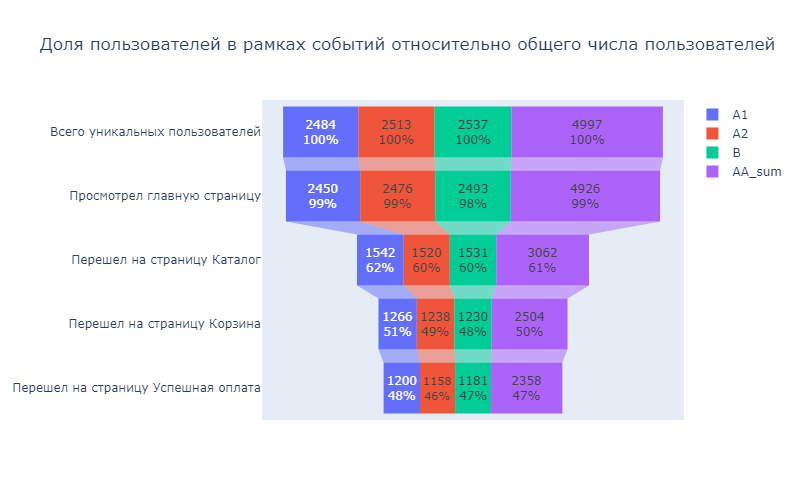

In [49]:
fig_group_event = go.Figure()

labels_events_total = data_total.query('index !="Посмотрел страницу Руководство"')['index'].tolist()

values_A1 = data_total.query('index !="Посмотрел страницу Руководство"')['A1'].tolist()
values_A2 = data_total.query('index !="Посмотрел страницу Руководство"')['A2'].tolist()
values_B = data_total.query('index !="Посмотрел страницу Руководство"')['B'].tolist()
values_AA = data_total.query('index !="Посмотрел страницу Руководство"')['AA_sum'].tolist()

fig_group_event.add_trace(go.Funnel(
    name = 'A1', y = labels_events_total, x = values_A1, textinfo = 'value+percent initial'))

fig_group_event.add_trace(go.Funnel(
    name = 'A2', orientation = 'h', y = labels_events_total, x = values_A2,
    textposition = 'inside', textinfo = 'value+percent initial'))

fig_group_event.add_trace(go.Funnel(
    name = 'B', orientation = 'h', y = labels_events_total, x = values_B,
    textposition = 'inside', textinfo = 'value+percent initial'))

fig_group_event.add_trace(go.Funnel(
    name = 'AA_sum', orientation = 'h', y = labels_events_total, x = values_AA,
    textposition = 'inside', textinfo = 'value+percent initial'))

fig_group_event.update_layout(title='Доля пользователей в рамках событий относительно общего числа пользователей',
                              width=800, height=500)
fig_group_event.show('png')

In [50]:
# собираем таблицу для проведения множественной проверки гипотез
data_A1_B_1 = {'test_name':['A1_B', 'A1_B', 'A1_B', 'A1_B', 'A1_B'],
        'event_name':['main', 'offers', 'cart', 'payment', 'tutorial'],
        'alpha_0.01':[0.01, 0.01, 0.01, 0.01, 0.01],
        'alpha_0.05':[0.05, 0.05, 0.05, 0.05, 0.05],
        'alpha_0.1':[0.1, 0.1, 0.1, 0.1, 0.1],
        'a_event':[data_total.loc[1,'A1'], data_total.loc[2,'A1'], data_total.loc[3,'A1'],
                   data_total.loc[4,'A1'], data_total.loc[5,'A1']],
        'a_total':[data_total.loc[0,'A1'], data_total.loc[0,'A1'], data_total.loc[0,'A1'],
                   data_total.loc[0,'A1'], data_total.loc[0,'A1']],
        'b_event':[data_total.loc[1,'B'], data_total.loc[2,'B'], data_total.loc[3,'B'],
                   data_total.loc[4,'B'], data_total.loc[5,'B']],
        'b_total':[data_total.loc[0,'B'], data_total.loc[0,'B'], data_total.loc[0,'B'],
                   data_total.loc[0,'B'], data_total.loc[0,'B']]} 
df_A1_B = pd.DataFrame(data_A1_B_1, index =['test1', 'test2', 'test3', 'test4', 'test5']) 
df_A1_B.head(1)

,test_name,event_name,alpha_0.01,alpha_0.05,alpha_0.1,a_event,a_total,b_event,b_total
test1,A1_B,main,0.01,0.05,0.1,2450,2484,2493,2537


In [51]:
# собираем таблицу для проведения множественной проверки гипотез
data_A2_B_2 = {'test_name':['A2_B', 'A2_B', 'A2_B', 'A2_B', 'A2_B'],
        'event_name':['main', 'offers', 'cart', 'payment', 'tutorial'],
        'alpha_0.01':[0.01, 0.01, 0.01, 0.01, 0.01],
        'alpha_0.05':[0.05, 0.05, 0.05, 0.05, 0.05],
        'alpha_0.1':[0.1, 0.1, 0.1, 0.1, 0.1],
        'a_event':[data_total.loc[1,'A2'], data_total.loc[2,'A2'], data_total.loc[3,'A2'],
                   data_total.loc[4,'A2'], data_total.loc[5,'A2']],
        'a_total':[data_total.loc[0,'A2'], data_total.loc[0,'A2'], data_total.loc[0,'A2'],
                   data_total.loc[0,'A2'], data_total.loc[0,'A2']],
        'b_event':[data_total.loc[1,'B'], data_total.loc[2,'B'], data_total.loc[3,'B'],
                   data_total.loc[4,'B'], data_total.loc[5,'B']],
        'b_total':[data_total.loc[0,'B'], data_total.loc[0,'B'], data_total.loc[0,'B'],
                   data_total.loc[0,'B'], data_total.loc[0,'B']]} 
df_A2_B = pd.DataFrame(data_A2_B_2, index =['test6', 'test7', 'test8', 'test9', 'test10']) 
df_A2_B.head(1)

,test_name,event_name,alpha_0.01,alpha_0.05,alpha_0.1,a_event,a_total,b_event,b_total
test6,A2_B,main,0.01,0.05,0.1,2476,2513,2493,2537


In [52]:
# собираем таблицу для проведения множественной проверки гипотез
data_AA_B_3 = {'test_name':['AA_B', 'AA_B', 'AA_B', 'AA_B', 'AA_B'],
        'event_name':['main', 'offers', 'cart', 'payment', 'tutorial'],
        'alpha_0.01':[0.01, 0.01, 0.01, 0.01, 0.01],
        'alpha_0.05':[0.05, 0.05, 0.05, 0.05, 0.05],
        'alpha_0.1':[0.1, 0.1, 0.1, 0.1, 0.1],
        'a_event':[data_total.loc[1,'AA_sum'], data_total.loc[2,'AA_sum'],
                   data_total.loc[3,'AA_sum'], data_total.loc[4,'AA_sum'], data_total.loc[5,'AA_sum']],
        'a_total':[data_total.loc[0,'AA_sum'], data_total.loc[0,'AA_sum'],
                   data_total.loc[0,'AA_sum'], data_total.loc[0,'AA_sum'], data_total.loc[0,'AA_sum']],
        'b_event':[data_total.loc[1,'B'], data_total.loc[2,'B'], data_total.loc[3,'B'],
                   data_total.loc[4,'B'], data_total.loc[5,'B']],
        'b_total':[data_total.loc[0,'B'], data_total.loc[0,'B'], data_total.loc[0,'B'],
                   data_total.loc[0,'B'], data_total.loc[0,'B']]} 
df_AA_B = pd.DataFrame(data_AA_B_3, index =['test11', 'test12', 'test13', 'test14', 'test15']) 
df_AA_B.head(1)

,test_name,event_name,alpha_0.01,alpha_0.05,alpha_0.1,a_event,a_total,b_event,b_total
test11,AA_B,main,0.01,0.05,0.1,4926,4997,2493,2537


In [53]:
# собираем таблицу для проведения множественной проверки гипотез
data_all_tests = pd.concat([df_A1_B, df_A2_B, df_AA_B], axis=0).reset_index()
data_all_tests.head(5)

,index,test_name,event_name,alpha_0.01,alpha_0.05,alpha_0.1,a_event,a_total,b_event,b_total
0,test1,A1_B,main,0.01,0.05,0.1,2450,2484,2493,2537
1,test2,A1_B,offers,0.01,0.05,0.1,1542,2484,1531,2537
2,test3,A1_B,cart,0.01,0.05,0.1,1266,2484,1230,2537
3,test4,A1_B,payment,0.01,0.05,0.1,1200,2484,1181,2537
4,test5,A1_B,tutorial,0.01,0.05,0.1,278,2484,279,2537


In [54]:
# функция для расчёта p-value
def get_p(row):
    sample1 = row['a_event'] / row['a_total']
    sample2 = row['b_event'] / row['b_total']
    p_combined = (row['a_event'] + row['b_event']) / (row['a_total'] + row['b_total'])
    difference = sample1 - sample2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/row['a_total'] + 1/row['b_total']))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value.round(3)

# считаем p-value для каждого случая
data_all_tests['p_value'] = data_all_tests.apply(get_p, axis=1)

# столбец result будет содержать True, если p-value меньше alpha
data_all_tests['result_alpha_0.01'] = data_all_tests['p_value'] < data_all_tests['alpha_0.01']
data_all_tests['result_alpha_0.05'] = data_all_tests['p_value'] < data_all_tests['alpha_0.05']
data_all_tests['result_alpha_0.1'] = data_all_tests['p_value'] < data_all_tests['alpha_0.1']
data_all_tests[['index', 'test_name', 'event_name', 'p_value', 'alpha_0.01',
                'result_alpha_0.01', 'alpha_0.05', 'result_alpha_0.05', 'alpha_0.1', 'result_alpha_0.1']]

,index,test_name,event_name,p_value,alpha_0.01,result_alpha_0.01,alpha_0.05,result_alpha_0.05,alpha_0.1,result_alpha_0.1
0,test1,A1_B,main,0.295,0.01,False,0.05,False,0.1,False
1,test2,A1_B,offers,0.208,0.01,False,0.05,False,0.1,False
2,test3,A1_B,cart,0.078,0.01,False,0.05,False,0.1,True
3,test4,A1_B,payment,0.212,0.01,False,0.05,False,0.1,False
4,test5,A1_B,tutorial,0.826,0.01,False,0.05,False,0.1,False
5,test6,A2_B,main,0.459,0.01,False,0.05,False,0.1,False
6,test7,A2_B,offers,0.920,0.01,False,0.05,False,0.1,False
7,test8,A2_B,cart,0.579,0.01,False,0.05,False,0.1,False
8,test9,A2_B,payment,0.737,0.01,False,0.05,False,0.1,False
9,test10,A2_B,tutorial,0.765,0.01,False,0.05,False,0.1,False


<div style="border:solid green 2px; padding: 20px">

P-value значительно больше 0.05 (по пропорциям в каждом событии). Значит, причин отвергать нулевую гипотезу и считать, что есть различия в пропорциях, нет. 

Для примера добавили сравнение с уровнем значимости 0.1. Как мы видим при уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. 

</div>

### Уровень значимости, скорректированный методом Холма

<div style="border:solid black 2px; padding: 20px">
    
Добавим расчет результатов тестирования, используя уровень значимости, скорректированный методом Холма (он позволяет скорректировать уровни значимости и при этом менее других методов снижает мощность тестов). 

Зададим уровень значимости 0.05.

</div>

In [55]:
m = len(data_all_tests) # число тестов
alpha = 0.05 # уровень значимости
# цикл для расчёта коррекции уровня значимости
result = []
for i in range(m): # получаем номер текущего теста и считаем коррекцию 
    result += [alpha / (m - i)]

data_all_tests['alpha_holm'] = pd.Series(result) # добавляем результат в столбец

# сравним p-value со скорректированным уровнем значимости
data_all_tests['test_result_corr'] = data_all_tests['p_value'] < data_all_tests['alpha_holm']
data_all_tests[['index', 'test_name', 'event_name', 'p_value', 'alpha_0.05',
                'result_alpha_0.05', 'alpha_holm', 'test_result_corr']]

,index,test_name,event_name,p_value,alpha_0.05,result_alpha_0.05,alpha_holm,test_result_corr
0,test1,A1_B,main,0.295,0.05,False,0.003333,False
1,test2,A1_B,offers,0.208,0.05,False,0.003571,False
2,test3,A1_B,cart,0.078,0.05,False,0.003846,False
3,test4,A1_B,payment,0.212,0.05,False,0.004167,False
4,test5,A1_B,tutorial,0.826,0.05,False,0.004545,False
5,test6,A2_B,main,0.459,0.05,False,0.005000,False
6,test7,A2_B,offers,0.920,0.05,False,0.005556,False
7,test8,A2_B,cart,0.579,0.05,False,0.006250,False
8,test9,A2_B,payment,0.737,0.05,False,0.007143,False
9,test10,A2_B,tutorial,0.765,0.05,False,0.008333,False


<div style="border:solid green 2px; padding: 20px">

Результаты тестов не изменились. Нет статистически значимых различий. Нет причин отвергать нулевую гипотезу.

Вывод: изменение шрифтов во всем приложении никак не влияет на количество пользователей в приложении в разрезе всех событий. Соответственно, дополнительной выгоды мы из этого изменения не получим.

</div>

### Вывод

<div style="border:solid blue 2px; padding: 20px">

**Количество пользователей по группам теста:**

| event                                     |  А1      | А2       | В         |
|:------------------------------------------|:--------:|:--------:| ---------:|
|**Всего уникальных пользователей в группе**| **2484** | **2513** | **2537**  |
|Просмотрел главную страницу                | 2450     | 2476     | 2493      |
|Перешел на страницу Каталог                | 1542     | 1520     | 1531      |
|Перешел на страницу Корзина                | 1266     | 1238     | 1230      |
|Перешел на страницу Успешная оплата        | 1200     | 1158     | 1181      |
|Посмотрел страницу Руководство             | 278      | 283      | 279       |

Провели множественную проверку гипотезы о равенстве долей между группами теста.
Нет статистически значимых различий. Нет причин отвергать нулевую гипотезу о равенстве.

Вывод: изменение шрифтов во всем приложении никак не влияет на количество пользователей в приложении в разрезе всех событий. Соответственно, дополнительной выгоды мы из этого изменения не получим.

</div>

[Начало_проекта](#Начало_проекта)

<a id="итоги"></a>

## Итоги исследования

<div style="border:solid blue 2px; padding: 20px">

Провели исследовательский анализ на данных мобильного приложения стартапа по продажам продуктов питания.

**Количество событий и пользователей в логе.**

| store  | Количество уникальных событий| Всего событий| Количество уникальных пользователей| Количество событий на пользователя| 
|:-------|:----------------------------:|:------------:|:----------------------------------:|:---------------------------------:|
|store   | 5                            |243713        | 7551                               | 32                                |


| Количество событий на пользователя  | mean | median | min | max  | 
|:------------------------------------|:----:|:------:|:---:|:----:|
|Количество событий на пользователя   | 32   |20      | 1   | 2307 |                          

На гистограмме видим длинных хвост по количеству событий на пользователя.

При срезе до 100 событий на пользователя, пик количества событий на пользователя в диапазоне 5-9 событий.

---

**Период отчета:** с 2019-07-25 по 2019-08-07 (14 дней):
* Минимальная дата 2019-07-25
* Максимальная дата 2019-08-07

По графику видим не одинаково полные данные за весь период:
* Июль 2826 событий (доля 1.2%).
* **Август 240887 событий (доля 98.8%).**

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 

На самом деле мы располагаем полными данные за 7 дней с 1 по 7 августа 2019 г.

Таким образом, отбросим данные за июль.

Отбросив данные за июль, потеряли только 17 уникальных пользователей из 7551.

**Время.**

Чаще всего пользователи заходят в приложение с 9:00 до 17:00.

Самое популярное время в приложении 14:00 и 15:00.

По за одну отчетную неделю меньше всего пользователей в среду. Данных за одну неделю недостаточно для того, чтобы говорить о тренде, будем иметь ввиду эту информацию для дальнейших исследований.

---

**События.**

В файле присутствуют 5 событий:


| Событие                           | Количество событий | Доля по частоте(%)| Доля пользователей, хоть раз совершивших событие (%)|
|:----------------------------------|:------------------:|:-----------------:| ---------------------------------------------------:|
|Просмотрел главную страницу        | 117328             |48.7               |  98.5                                               |
|Перешел на страницу Каталог        | 46333              |19.2               |  61.0                                               |
|Перешел на страницу Корзина        | 42303              |17.6               |  49.6                                               |
|Перешел на страницу Успешная оплата| 33918              |14.1               |  47.0                                               |
|Посмотрел страницу Руководство     | 1005               |0.4                |  11.1                                               |


* Самое популярное событие 'Просмотрел главную страницу':
    - Доля по частоте событий 48.7%.
    - Доля по количеству пользователей 36.9%.
    - Доля пользователей, хоть раз совершивших данное событие 98.5%. Предположение, почему в первом пункте не 100%: пользователь мог зайти по рекламной ссылке на конкретный товар, или получить ссылку на конкретный товар от знакомого.

* Считаем, что все события происходят в порядке, который мы наблюдаем при сортировке частоты событий по убыванию:
1. Просмотрел главную страницу
2. Перешел на страницу Каталог
3. Перешел на страницу Корзина
4. Перешел на страницу Успешная оплата

* Исключение - это событие 'Посмотрел страницу Руководство'. Данную страницу пользователь мог смотреть в любой последовательности после посещения главной страницы. Доля по частоте событий 0.4%. В связи с этим данное событие не будем учитывать при расчете воронки.

---

**Воронка событий:**

| event                              |  value       | percent initial (%)| percent previous (%) |
|:-----------------------------------|:------------:|:------------------:| --------------------:|
|Просмотрел главную страницу         | 7419         | 100                | 100                  |
|Перешел на страницу Каталог         | 4593         | 62                 | 62                   |
|Перешел на страницу Корзина         | 3734         | 50                 | 81                   |
|Перешел на страницу Успешная оплата | 3539         | 48                 | 95                   |


* На шаге 'Перешел на страницу Каталог' теряем больше всего пользователей (percent previous 62%).

* От первого события до оплаты доходит 48% пользователей.

Количество шагов в событиях:
* 111 пользователей миновали шаг 'Просмотрел главную страницу'.
* У 110 пользователей из 3539, у которых оплата прошла успешно было только 3 шага. У остальных было сделано все 4 шага.

---

**Количество пользователей по группам теста:**

| event                                     |  А1      | А2       | В         |
|:------------------------------------------|:--------:|:--------:| ---------:|
|**Всего уникальных пользователей в группе**| **2484** | **2513** | **2537**  |
|Просмотрел главную страницу                | 2450     | 2476     | 2493      |
|Перешел на страницу Каталог                | 1542     | 1520     | 1531      |
|Перешел на страницу Корзина                | 1266     | 1238     | 1230      |
|Перешел на страницу Успешная оплата        | 1200     | 1158     | 1181      |
|Посмотрел страницу Руководство             | 278      | 283      | 279       |

Провели множественную проверку гипотезы о равенстве долей между группами теста.
Нет статистически значимых различий. Нет причин отвергать нулевую гипотезу о равенстве.

**Вывод:** изменение шрифтов во всем приложении никак не влияет на количество пользователей в приложении в разрезе всех событий. Соответственно, дополнительной выгоды мы из этого изменения не получим.

</div>